In [1]:
import os
import random
import numpy as np
import imageio
from keras.layers import Input, Dense, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Flatten, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
%matplotlib inline  

Using TensorFlow backend.


In [2]:
## Load dataset

In [3]:
def load_dataset(path):
    files = os.listdir(path)
    x = []
    for file in files: # number of files to go through
        im = imageio.imread(os.path.join(path, file))
        x.append(im)
    x = np.asarray(x)
    return x

In [4]:
path_train_orig = './Food11_256/training_256'
path_val_orig = './Food11_256/validation_256'

x_train = load_dataset(path_train_orig)
x_val = load_dataset(path_val_orig)

print('original dataset:', np.shape(x_train), np.shape(x_val))

original dataset: (9860, 256, 256, 3) (3428, 256, 256, 3)


In [5]:
path_train_date = './Food11_256/training_256_datestamp'
path_val_date = './Food11_256/validation_256_datestamp'

x_train_date = load_dataset(path_train_date)
x_val_date = load_dataset(path_val_date)

print('datestamped dataset:', np.shape(x_train_date), np.shape(x_val_date))

datestamped dataset: (9860, 256, 256, 3) (3428, 256, 256, 3)


In [6]:
x_train = x_train.astype('float32') / 255.0
x_val  = x_val.astype('float32') / 255.0
x_train_date = x_train_date.astype('float32') / 255.0
x_val_date  = x_val_date.astype('float32') / 255.0

In [7]:
## Convolutional AutoEncoder

In [8]:
epochs = 100
batch_size = 16
in_shape = (x_train.shape[1:])

In [9]:
input_img = Input(shape=(in_shape)) 
x = Conv2D(96, (3, 3), padding='same')(input_img)  
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)  
x = Conv2D(48, (3, 3), padding='same')(x)   
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(48, (3, 3), padding='same')(encoded) 
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)      
x = Conv2D(96, (3, 3), padding='same')(x)  
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)  
x = Conv2D(3, (3, 3), padding='same')(x)  
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [10]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 96)      2688      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 96)      384       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 96)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 96)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 48)      41520     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 48)      192       
__________

In [11]:
history = model.fit(x_train_date, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val_date, x_val),
                    #callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')],
                   shuffle=True
                   )

Train on 9860 samples, validate on 3428 samples
Epoch 1/100
9860/9860 [==============================] - 247s 25ms/step - loss: 0.5245 - val_loss: 0.5074
Epoch 2/100
9860/9860 [==============================] - 243s 25ms/step - loss: 0.5073 - val_loss: 0.5048
Epoch 3/100
9860/9860 [==============================] - 243s 25ms/step - loss: 0.5041 - val_loss: 0.5046
Epoch 4/100
9860/9860 [==============================] - 244s 25ms/step - loss: 0.5033 - val_loss: 0.5071
Epoch 5/100
9860/9860 [==============================] - 244s 25ms/step - loss: 0.5026 - val_loss: 0.5028
Epoch 6/100
9860/9860 [==============================] - 243s 25ms/step - loss: 0.5024 - val_loss: 0.5056
Epoch 7/100
9860/9860 [==============================] - 243s 25ms/step - loss: 0.5018 - val_loss: 0.5074
Epoch 8/100
9860/9860 [==============================] - 244s 25ms/step - loss: 0.5019 - val_loss: 0.5026
Epoch 9/100
9860/9860 [==============================] - 244s 25ms/step - loss: 0.5016 - val_loss: 0.502

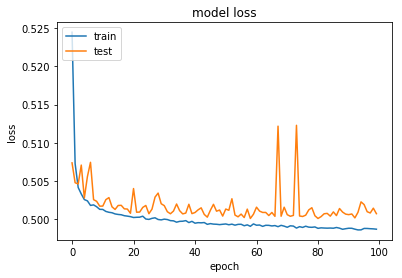

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
## Visualize original image and reconstructed image

In [14]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=9):
    n = num
    plt.figure(figsize=(23, 5))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(in_shape))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(in_shape))
        ax.get_xaxis().set_visible(False)  
        ax.get_yaxis().set_visible(False)
    plt.show()

In [15]:
def random_subset(iterator, K):
    result = []
    N = 0

    for item in iterator:
        N += 1
        if len(result) < K:
            result.append(item)
        else:
            s = int(random.random() * N)
            if s < K:
                result[ s ] = item

    return result

In [16]:
import math

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [17]:
path_test_orig = './Food11_256/evaluation_256'
x_test = load_dataset(path_test_orig)
x_test  = x_test.astype('float32') / 255.0

path_test_date = './Food11_256/evaluation_256_datestamp'
x_test_date = load_dataset(path_test_date)
x_test_date  = x_test_date.astype('float32') / 255.0

In [18]:
d_sum = 0
for i in range(len(x_test)):
    dateimg = np.asarray([x_test_date[i]])
    nodateimg = np.asarray([x_test[i]])
    predictions = model.predict(dateimg)
    d=psnr(predictions,nodateimg)
    d_sum+=d
#         showOrigDec(nodateimg,predictions,1)
#         print("psnr:",d)
print(d_sum/len(x_test))

79.73468492377255


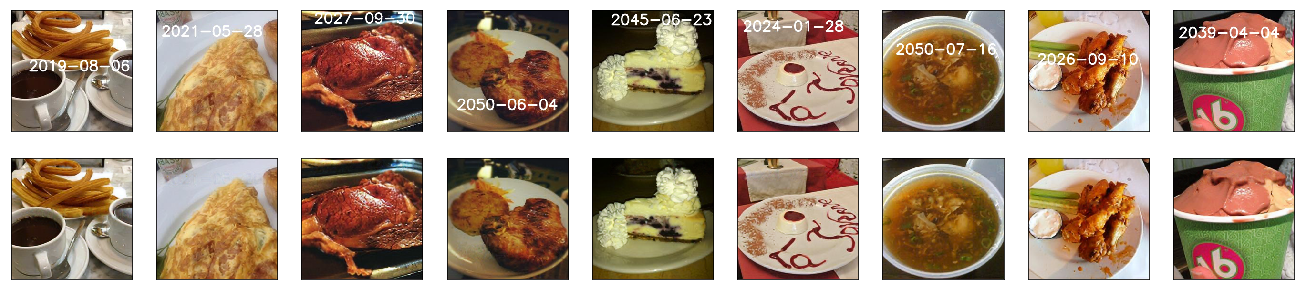

In [19]:
n = 9
samples = np.asarray(random_subset(x_test_date, n))
predictions = model.predict(samples)
showOrigDec(samples,predictions,n)